# Evaluations: Basis functions and Electostatic potential

Other than the electron density $\rho(\mathbf{r})$, the one-electron reduced density matrix (1-RDM) $\gamma(\mathbf{r}, \mathbf{r}')$ and their derived properties, [`gbasis`](http://gbasis.qcdevs.org/intro.html) supports the evaluation of the basis functions $\phi_i(\mathbf{r})$ and the electrostatic potential $v(\mathbf{r})$. These properties are commonly used in the analysis of electronic structure calculations and are obtainable from other packages (for their supported methods). In this tutorial, we will show how to evaluate these properties using `gbasis` for a set of points in space. We will also take the opportunity to show how to interface `gbasis` with other packages to load the data ([`iodata`](https://iodata.readthedocs.io/en/latest/)) and to define the grid of points  and export the results as cube files ([`grid`](https://grid.qcdevs.org/))

## Load data

To evaluate properties dependent on the system state, we need its wavefunction or an equivalent representation. In `gbasis`, this is done through the **one-electron reduced density matrix** (1-RDM). As a case example, the following code will load this data from a `fchk` file corresponding to a `ub3lyp/aug-cc-pvtz` calculation on ethylene. The file can be [downloaded]() from the data folder of this repository. For simplicity, we will be using the [`iodata`](https://iodata.readthedocs.io/en/latest/) package to load the data:

In [1]:
import numpy as np
from iodata import load_one
from gbasis.wrappers import from_iodata

# formchk file available from
#

# load molecule info and basis from fchk file
mol_data = load_one("./data/ch2o_q_0.fchk")
ao_basis = from_iodata(mol_data)  # basis definition for the atomic orbitals

# one electron RDM from fchk file
rdm = mol_data.one_rdms["scf"]

# atomic coordinates and numbers
atcoords = mol_data.atcoords
atnums = mol_data.atnums

print(f"Loaded: {mol_data.title}")
print(f"Basis: {mol_data.obasis_name}")
print(f"Atom numbers: {mol_data.atnums}")
print(f"Atom coordinates:\n{mol_data.atcoords}")
print(f"Molecule is planar: {np.allclose(atcoords[:, 2], 0 , atol=1e-6)}")
print(f"Number of atomic orbitals: {len(ao_basis)}")
print(f"One electron RDM shape: {rdm.shape}")

Loaded: ch2o_q+0 ub3lyp/aug-cc-pvtz opt-stable-freq
Basis: aug-cc-pvtz
Atom numbers: [8 6 1 1]
Atom coordinates:
[[ 2.27823914e+00  4.13899085e-07  3.12033662e-07]
 [ 1.01154892e-02  1.09802629e-07 -6.99333116e-07]
 [-1.09577141e+00  1.77311416e+00  1.42544321e-07]
 [-1.09577166e+00 -1.77311468e+00  2.44755133e-07]]
Molecule is planar: True
Number of atomic orbitals: 46
One electron RDM shape: (138, 138)


## Define auxiliary grids

For the next examples two grids will be used:
1. A uniform `grid` spanning a cube containing the molecule (support export to cube files)
2. A planar mesh spanning the molecular plane (that will be used to plot the calculated properties in the plane)

In [2]:
from grid import UniformGrid
from grid import UniformInteger, LinearInfiniteRTransform, Tensor1DGrids

# create a uniform grid for the molecule (interface to cube files)
mol_grid = UniformGrid.from_molecule(atnums, atcoords, spacing=0.75, extension=5.0, rotate=True)

# create a planar grid for the molecule
coord_limit = 5
plt_pts = 40
plt_lmts = [-coord_limit, coord_limit, -coord_limit, coord_limit]
x_vals = np.linspace(-coord_limit, coord_limit, plt_pts)
y_vals = x_vals

# Sample 3D points uniformly in the molecular xy-plane (z=0)
x_vals, y_vals = np.meshgrid(x_vals, y_vals)
x_vals, y_vals = x_vals.flatten(), y_vals.flatten()
z_vals = np.zeros_like(x_vals)
points = np.array([x_vals, y_vals, z_vals]).T  # gbasis evaluates at 3D points

print(f"Number of points in the molecule grid: {mol_grid.size}")
print(f"Number of points in the planar grid: {len(points)}")

Number of points in the molecule grid: 4788
Number of points in the planar grid: 1600


## Obtain HOMO and LUMO

[`gbasis`](http://gbasis.qcdevs.org/intro.html) supports the evaluation of the basis functions $\phi_i(\mathbf{r})$ for a set of points in space. It also supports the application of an arbitrary transformation (defined by a matrix) to the basis functions before their evaluation. This is useful for evaluating any function given its expansion in the basis given basis set. For example the following code will evaluate the HOMO and LUMO orbitals of formaldehyde. The results will be stored in a cube file for easier interface with any molecular visualizer.

#### Evaluate orbitals in uniform grid
The following code shows how to evaluate the basis in the uniform grid points. As we desire to evaluate the MOs instead of the basis functions, the argument transform is used with the matrix of the basis set expansion coefficients is used (trasnforms from AO to MO).

In [3]:
from gbasis.evals.eval import evaluate_basis

# extract MO coefficients from iodata object
mo_coeffs = mol_data.mo.coeffs

# Compute expected MO values using GBasis
mo_vals = evaluate_basis(ao_basis, mol_grid.points, transform=mo_coeffs.T)
print(f"MO orbital values shape: {mo_vals.shape} -> ", end="")
print(f"{mo_vals.shape[0]} MOs, {mo_vals.shape[1]} points")

MO orbital values shape: (276, 4788) -> 276 MOs, 4788 points


#### Export desired orbitals to cube files

On this second part we select the orbitals we want to extract and a cube file is generated with the results. It is important to understand the correspondence between the values generated by `gbasis` and the corresponding MOs. For each point, the function `evaluate_basis` returns an array of floats, corresponding to the corresponding orbitals sorted by increasing energy values from left to right (index 0 corresponds to the first orbital). In the case of an unrestricted calculation, the alpha orbitals are listed first.

In [4]:
# Save the HOMO orbital (alpha)
homo_vals = mo_vals[int(mol_data.nelec / 2 - 1), :]
mol_grid.generate_cube(
    fname="ch2o_homo_alpha.cube",
    data=homo_vals,
    atcoords=atcoords,
    atnums=atnums,
    pseudo_numbers=mol_data.atcorenums,
)

# Save the HOMO orbital (beta)
homo_vals = mo_vals[int(mo_vals.shape[0] / 2 + mol_data.nelec / 2 - 1), :]
mol_grid.generate_cube(
    fname="ch2o_homo_beta.cube",
    data=homo_vals,
    atcoords=atcoords,
    atnums=atnums,
    pseudo_numbers=mol_data.atcorenums,
)

# Save the LUMO orbital (alpha)
lumo_vals = mo_vals[int(mol_data.nelec / 2), :]
mol_grid.generate_cube(
    fname="ch2o_lumo_alpha.cube",
    data=lumo_vals,
    atcoords=atcoords,
    atnums=atnums,
    pseudo_numbers=mol_data.atcorenums,
)

# Save the LUMO orbital (beta)
lumo_vals = mo_vals[int(mo_vals.shape[0] / 2 + mol_data.nelec / 2), :]
mol_grid.generate_cube(
    fname="ch2o_lumo_beta.cube",
    data=lumo_vals,
    atcoords=atcoords,
    atnums=atnums,
    pseudo_numbers=mol_data.atcorenums,
)

## Plot HOMO

The next code computes the HOMO (alpha) for the grid of points in the molecular plane. A contour plot representation is also generated.

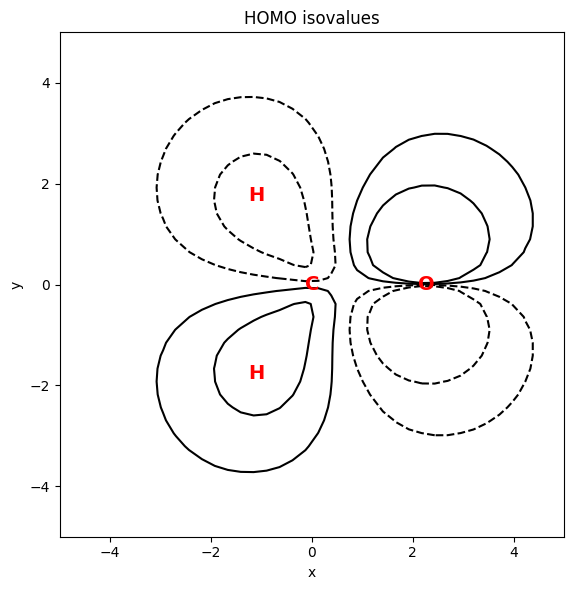

In [5]:
import matplotlib.pyplot as plt

# Compute expected MO values using GBasis
mo_vals = evaluate_basis(ao_basis, points, transform=mo_coeffs.T)
homo_vals = mo_vals[int(mol_data.nelec / 2 - 1), :]

# plot the HOMO
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(111, aspect="equal")
# Plot the electron density as contour plot
ax1.set_title("HOMO isovalues")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

X = points[:, 0].reshape(plt_pts, plt_pts)
Y = points[:, 1].reshape(plt_pts, plt_pts)
Z = homo_vals.reshape(plt_pts, plt_pts)
# Add contour plot of the electron density
levels = np.array([-0.1, -0.03, 0.03, 0.1])
cs = ax1.contour(X, Y, Z, levels, colors="k")
# Add atomic symbols to the plots
symbols = ["O", "C", "H", "H"]
xy_coords = atcoords[:, :2]
for coord, symbol in zip(xy_coords, symbols):
    ax1.text(
        coord[0],
        coord[1],
        symbol,
        color="red",
        ha="center",
        va="center",
        fontsize=14,
        fontweight="bold",
    )

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Evaluate electrostatic potential

The following example shows how to evaluate the electrostatic potential of formaldehyde, for this the same grids will be used. 

In [6]:
from gbasis.evals.electrostatic_potential import electrostatic_potential

# Compute electrostatic potential at grid points
v_elect = electrostatic_potential(
    basis=ao_basis,
    one_density_matrix=rdm,
    points=mol_grid.points,
    nuclear_coords=atcoords,
    nuclear_charges=mol_data.atcorenums,
)
mol_grid.generate_cube(
    fname="ch2o_pot.cube",
    data=v_elect,
    atcoords=atcoords,
    atnums=atnums,
    pseudo_numbers=mol_data.atcorenums,
)

The following code computes the electrostatic potential for the grid of points in the molecular plane. A surface plot a heatmap representation is generated

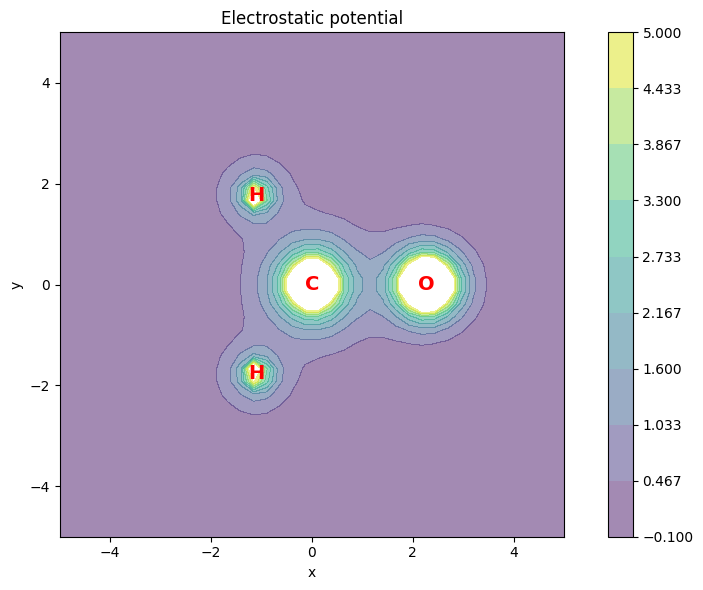

In [12]:
v_elect_xy = electrostatic_potential(
    basis=ao_basis,
    one_density_matrix=rdm,
    points=points,
    nuclear_coords=atcoords,
    nuclear_charges=mol_data.atcorenums,
)

# plot the electron density
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(111, aspect="equal")
# Plot the electron density as contour plot
ax1.set_title("Electrostatic potential")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

X = points[:, 0].reshape(plt_pts, plt_pts)
Y = points[:, 1].reshape(plt_pts, plt_pts)
Z = v_elect_xy.reshape(plt_pts, plt_pts)
# Add contour plot of the electron density
plt.contourf(X, Y, Z, 10, cmap="viridis", alpha=0.5, levels=np.linspace(-0.1, 5, 10))
plt.colorbar()

# Add atomic symbols to the plots
symbols = ["O", "C", "H", "H"]
xy_coords = atcoords[:, :2]
for coord, symbol in zip(xy_coords, symbols):
    ax1.text(
        coord[0],
        coord[1],
        symbol,
        color="red",
        ha="center",
        va="center",
        fontsize=14,
        fontweight="bold",
    )

plt.tight_layout()  # Adjust layout for better spacing
plt.show()